<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [1]:
%%bash
pip install --no-cache-dir -qU \
  tensorflow tensorflow-probability[tf]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.5/615.5 MB 162.3 MB/s eta 0:00:00


## Models with multiple inputs and outputs

In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import model_selection, preprocessing

origin = "https://www.kaggle.com/api/v1/datasets/download/johnsmith88/heart-disease-dataset/heart.csv"
df_raw = pd.read_csv(tf.keras.utils.get_file(origin=origin))

df_raw["sex"] = df_raw["sex"].map({0: "female", 1: "male"})
df_raw["cp"] = df_raw["cp"].map({0: "typical angina", 1: "atypical angina",
    2: "non-anginal pain", 3: "asymptomatic"})
df_raw["fbs"] = df_raw["fbs"].map({0: "false", 1: "true"})
df_raw["restecg"] = df_raw["restecg"].map({0: "normal",
    1: "ST-T wave abnormality", 2: "left ventricular hypertrophy"})
df_raw["exang"] = df_raw["exang"].map({0: "no", 1: "yes"})
df_raw["slope"] = df_raw["slope"].map({0: "upsloping", 1: "flat",
    2: "downsloping"})
df_raw["thal"] = df_raw["thal"].map({0: "normal", 1: "normal",
    2: "fixed defect", 3: "reversable defect"})

target_encoder = preprocessing.LabelEncoder()
df_raw["target"] = target_encoder.fit_transform(df_raw["target"])

thalach_scaler = preprocessing.StandardScaler()
df_raw["thalach"] = thalach_scaler.fit_transform(df_raw[["thalach"]])

df_train, df_test = model_selection.train_test_split(df_raw,
    test_size=0.1, random_state=42)
df_test.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
294,56,female,typical angina,200,288,true,normal,-0.700783,yes,4.0,upsloping,2,reversable defect,0
921,58,male,typical angina,146,218,false,ST-T wave abnormality,-1.918465,no,2.0,flat,1,reversable defect,0
464,67,female,non-anginal pain,115,564,false,normal,0.473411,no,1.6,flat,0,reversable defect,1
107,62,male,atypical angina,120,281,false,normal,-2.005443,no,1.4,flat,1,reversable defect,0
629,65,male,asymptomatic,138,282,true,normal,1.082252,no,1.4,flat,1,fixed defect,0


Test result:


{'loss': 0.5809427499771118,
 'target_acc': 0.893203854560852,
 'target_loss': 0.23291799426078796,
 'thalach_loss': 0.3421125113964081,
 'thalach_mae': 0.44350966811180115}

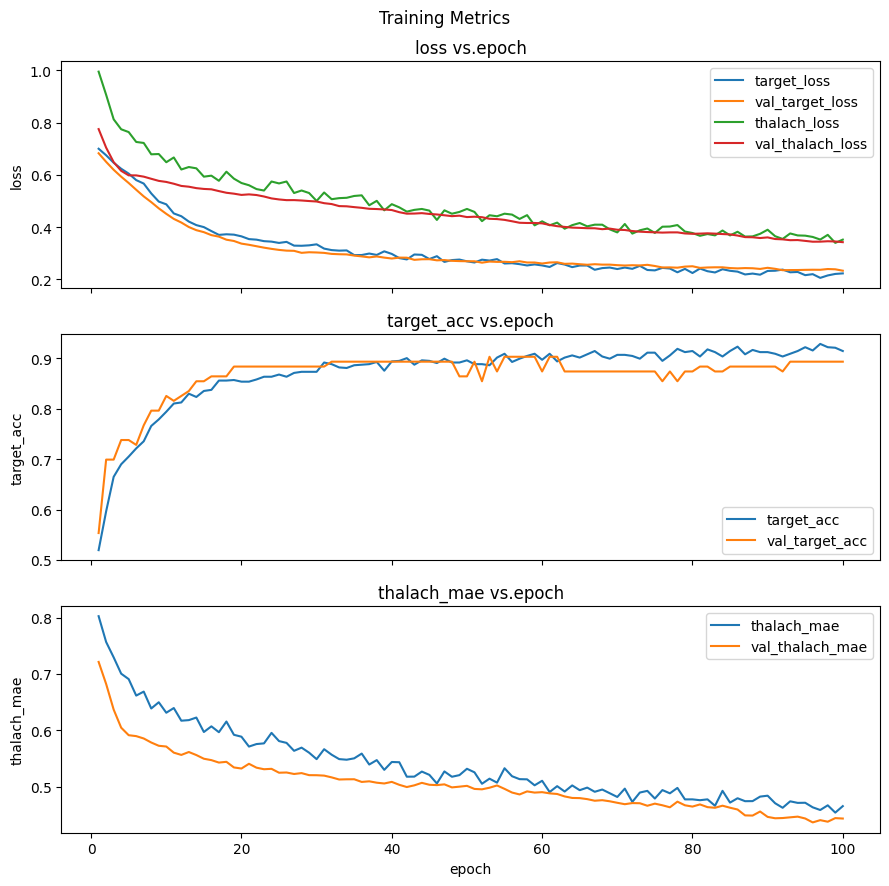

In [2]:
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def df_to_ds(df, shuffle=False):
    x = {k: v.values[:, tf.newaxis] for k, v in df.items()}
    y = {"target": x.pop("target"), "thalach": x.pop("thalach")}
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y)).cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size=64).prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = df_to_ds(df=df_train, shuffle=True)
ds_test = df_to_ds(df=df_test, shuffle=False)

inputs = {}
for name, spec in ds_train.element_spec[0].items():
    inputs[name] = tf.keras.Input(name=name, shape=(1,), dtype=spec.dtype)

features = []
for name in ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]:
    dtype = ds_train.element_spec[0][name].dtype
    if dtype=="string":
        lookup = tf.keras.layers.StringLookup(output_mode="int")
    else:
        lookup = tf.keras.layers.IntegerLookup(output_mode="int")
    lookup.adapt(data=ds_train.map(lambda x, _: x[name]))
    embedding = tf.keras.Sequential(layers=[
        lookup,
        tf.keras.layers.Embedding(input_dim=lookup.vocabulary_size(),
            output_dim=round(lookup.vocabulary_size()/2)),
        tf.keras.layers.Flatten()
    ])
    features.append(embedding(inputs[name]))

for name in ["age", "trestbps", "chol", "oldpeak"]:
    normalizer = tf.keras.layers.Normalization(axis=None)
    normalizer.adapt(data=ds_train.map(lambda x, _: x[name]))
    features.append(normalizer(inputs[name]))

features = tf.keras.layers.Concatenate(axis=-1)(features)

net = tf.keras.Sequential(layers=[
    tf.keras.layers.Dense(units=32, activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(units=64, activation=tf.keras.activations.relu,
        kernel_regularizer=tf.keras.regularizers.L2(l2=1e-6)),
    tf.keras.layers.Dropout(rate=0.2)
])

h = net(inputs=features)

outputs = {
    "target": tf.keras.layers.Dense(name="target", units=1,
        activation=tf.keras.activations.sigmoid)(inputs=h),
    "thalach": tf.keras.layers.Dense(name="thalach", units=1,
        activation=tf.keras.activations.linear)(inputs=h)
}

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss = {
        "target": tf.keras.losses.BinaryCrossentropy(),
        "thalach": tf.keras.losses.MeanSquaredError()
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics = {
        "target": [
            tf.keras.metrics.BinaryAccuracy(name="acc")
        ],
        "thalach": [
            tf.keras.metrics.MeanAbsoluteError(name="mae")
        ]
    }
)
os.makedirs("models", exist_ok=True)
ckptPath = "models/training.weights.h5"
ckptSave = tf.keras.callbacks.ModelCheckpoint(monitor="val_loss",
    mode="min", save_best_only=True, save_weights_only=True,
    filepath=ckptPath)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",
    mode="min", patience=5, factor=0.9)

history = model.fit(x=ds_train, validation_data=ds_test, epochs=100,
    callbacks=[ckptSave, reduceLR], verbose=False)
df_history = pd.DataFrame(history.history)
df_history["epoch"] = df_history.index + 1

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(9, 9))
fig.suptitle(t="Training Metrics")
axes[0].set_title(label="loss vs.epoch")
axes[0].set_ylabel(ylabel="loss")
for l in ["target", "thalach"]:
    sns.lineplot(ax=axes[0], label=f"{l}_loss", data=df_history,
        x="epoch", y=f"{l}_loss")
    sns.lineplot(ax=axes[0], label=f"val_{l}_loss", data=df_history,
        x="epoch", y=f"val_{l}_loss")
axes[0].legend(loc="best")

for ax, m in zip(axes[1:], ["target_acc", "thalach_mae"]):
    ax.set_title(label=f"{m} vs.epoch")
    ax.set_ylabel(ylabel=m)
    sns.lineplot(ax=ax, label=m, data=df_history,
        x="epoch", y=m)
    sns.lineplot(ax=ax, label=f"val_{m}", data=df_history,
        x="epoch", y=f"val_{m}")
    ax.legend(loc="best")

axes[2].set_xlabel(xlabel="epoch")
fig.tight_layout()
fig.show()

model.load_weights(ckptPath)
print("Test result:")
model.evaluate(x=ds_test, return_dict=True, verbose=False)

In [37]:
import tensorflow as tf

x_sample = {k: v.values[:, tf.newaxis] for k, v in df_test[0::10].items()}
y_sample = {"target": x_sample.pop("target"),
    "thalach": x_sample.pop("thalach")}
y_pred = model(inputs=x_sample)

target_true = target_encoder.inverse_transform(
    y=y_sample["target"].squeeze())
target_pred = tf.cast(y_pred["target"] > 0.5, tf.int64)
target_pred = target_encoder.inverse_transform(
    y=tf.squeeze(target_pred))
acc = tf.keras.metrics.BinaryAccuracy()(
    y_true=target_true, y_pred=target_pred)
print("target accuracy:", acc)

thalach_true = thalach_scaler.inverse_transform(
    X=y_sample["thalach"])
thalach_pred = thalach_scaler.inverse_transform(
    X=y_pred["thalach"])
mae = tf.keras.metrics.MeanAbsoluteError()(
    y_true=thalach_true, y_pred=thalach_pred)
print("thalach mae:", mae)

target accuracy: tf.Tensor(0.90909094, shape=(), dtype=float32)
thalach mae: tf.Tensor(6.954035, shape=(), dtype=float32)


## Customize training

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


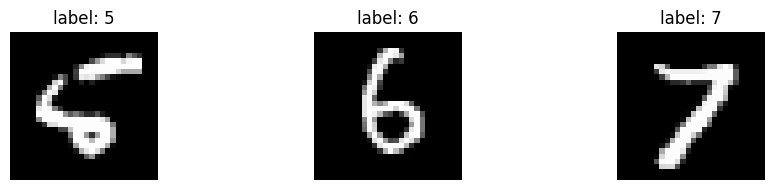

(TensorSpec(shape=(None, 28, 28), dtype=tf.uint8, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
fig, axes =  plt.subplots(nrows=1, ncols=3, figsize=(10, 2))
for ax, x, y in zip(axes, x_plt, y_plt):
    ax.set_title(label=f"label: {y}")
    ax.imshow(X=x, cmap="gray")
    ax.axis("off")
fig.tight_layout()
plt.show()

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y)).cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=32)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

Training duration: 52s


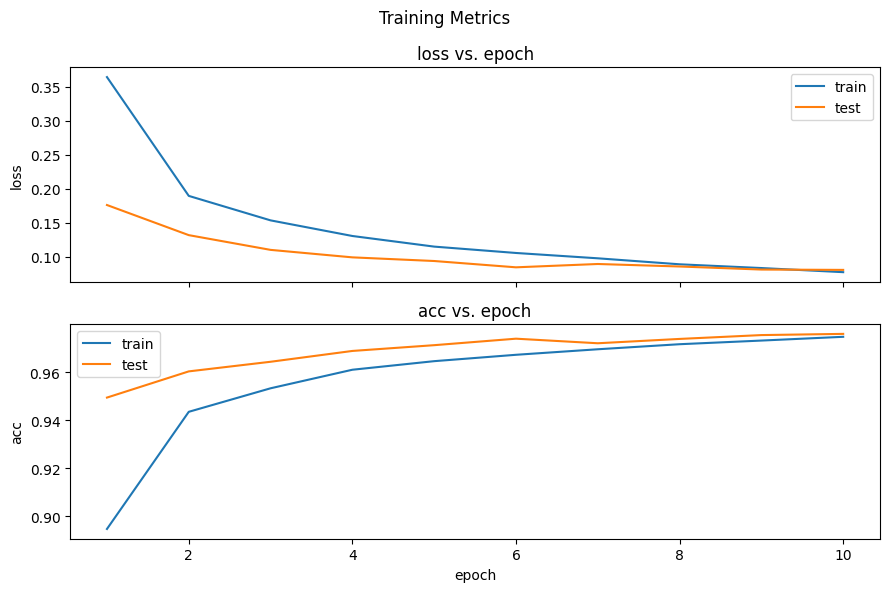

In [ ]:
import keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

@keras.saving.register_keras_serializable()
class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.preprocess = tf.keras.Sequential(layers=[
            tf.keras.layers.Rescaling(scale=1./255),
            tf.keras.layers.Reshape(target_shape=(784,))
        ])

    @tf.function
    def call(self, inputs):
        return self.preprocess(inputs=inputs)

x = tf.keras.Input(name="Images", shape=(28, 28), dtype=tf.float32)
h = PreprocessingLayer(name="preprocessing")(inputs=x)
h = tf.keras.layers.Dense(units=64,
    activation=tf.keras.activations.relu,
    kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))(inputs=h)
h = tf.keras.layers.Dropout(rate=0.2)(inputs=h)
y = tf.keras.layers.Dense(units=10,
    activation=tf.keras.activations.softmax)(inputs=h)
model = tf.keras.Model(inputs=x, outputs=y)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
model.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
metrics = [
    tf.keras.metrics.Mean(name="loss"),
    tf.keras.metrics.SparseCategoricalAccuracy(name="acc")
]

os.makedirs("models", exist_ok=True)
ckptPath = "models/training.weights.h5"
ckptModel = tf.keras.callbacks.ModelCheckpoint(monitor="test_acc",
    mode="max", save_best_only=True, save_weights_only=True, filepath=ckptPath)
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="test_loss",
    mode="min", patience=1, factor=0.9)
callbacks = tf.keras.callbacks.CallbackList(model=model, add_history=True,
    callbacks=[ckptModel, reduceLR])

@tf.function(reduce_retracing=True)
def train_step(data):
    x, y = data
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = loss_fn(y_true=y, y_pred=y_pred)
    vars = model.trainable_variables
    grads = tape.gradient(target=loss, sources=vars)
    model.optimizer.apply_gradients(grads_and_vars=zip(grads, vars))
    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)
    return {f"train_{m.name}": m.result() for m in metrics}

@tf.function(reduce_retracing=True)
def test_step(data):
    x, y = data
    y_pred = model(inputs=x, training=False)
    loss = loss_fn(y_true=y, y_pred=y_pred)
    for m in metrics:
        if m.name=="loss":
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)
    return {f"test_{m.name}": m.result() for m in metrics}

start_time = time.time()
history, logs = [], {}
callbacks.on_train_begin(logs=logs)
for epoch in range(10):
    callbacks.on_epoch_begin(epoch=epoch, logs=logs)

    for data in ds_train:
        logs = train_step(data=data)
    for m in metrics:
        m.reset_state()

    for data in ds_test:
        logs_test = test_step(data=data)
    logs.update(logs_test)
    for m in metrics:
        m.reset_state()

    callbacks.on_epoch_end(epoch=epoch, logs=logs)
    history.append({k: v.numpy() for k, v in logs.items()})
callbacks.on_train_end(logs=logs)
print("Training duration: %2.fs"%(time.time() - start_time))

df_history = pd.DataFrame(history)
df_history["epoch"] = df_history.index + 1
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 6))
fig.suptitle(t="Training Metrics")
for ax, m in zip(axes, metrics):
    ax.set_title(label=f"{m.name} vs. epoch")
    ax.set_ylabel(ylabel=m.name)
    sns.lineplot(ax=ax, label="train", data=df_history,
        x="epoch", y=f"train_{m.name}")
    sns.lineplot(ax=ax, label="test", data=df_history,
        x="epoch", y=f"test_{m.name}")
    ax.legend(loc="best")
axes[1].set_xlabel(xlabel="epoch")
fig.tight_layout()
fig.show()

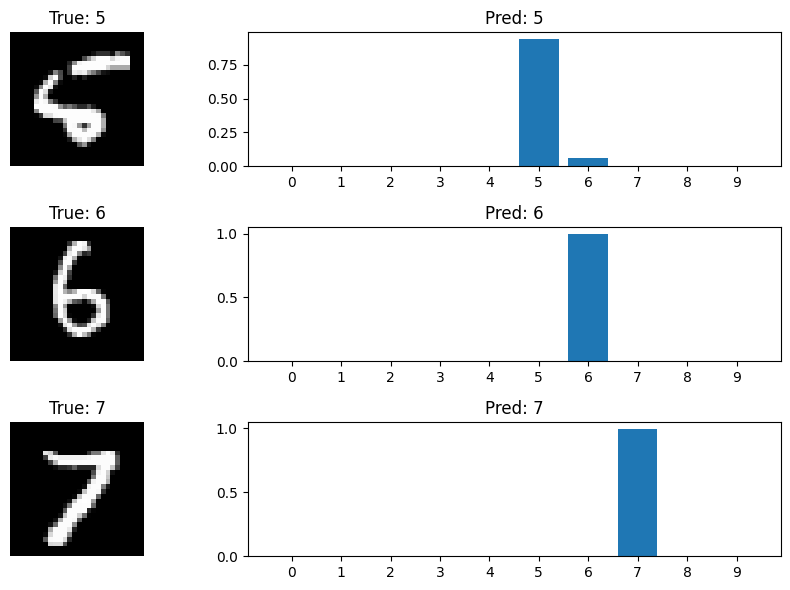

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x_plt = x_test[8:3*13:13]
y_plt = y_test[8:3*13:13]
model.load_weights(ckptPath)
probs = model(inputs=x_plt)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)
for ax, x, y, prob in zip(axes, x_plt, y_plt, probs):
    ax[0].set_title(label=f"True: {y}")
    ax[0].imshow(X=x, cmap="gray")
    ax[0].axis("off")
    ax[1].set_title(label=f"Pred: {tf.math.argmax(input=prob)}")
    ax[1].bar(x=np.arange(len(prob)), height=prob)
    ax[1].set_xticks(ticks=np.arange(len(prob)))
fig.tight_layout()
plt.show()